In [202]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta

#Plotting
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

#DOLfYN package
import dolfyn
#import dolfyn.adp.api as api
from dolfyn.adv import api

### ADV

In [68]:
# Read a file containing adv data:
dat = dolfyn.read('ADV/DEPL_204a.VEC')

# Clean the file using the Goring+Nikora method:
dat.sel(time=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000'))

print('creating despike mask')
despikeMask = api.clean.GN2002(dat.vel, npt = len(dat.time))
print('creating correlation mask')
corrMask = np.where((dat.corr.sel(beam = 1) < 65) |
         (dat.corr.sel(beam = 2) < 65) |
         (dat.corr.sel(beam = 3) < 65), True, False)
mask = np.logical_or(despikeMask, corrMask)

print('interpolating data')
# Linearly interpolate all gaps <= 32 data points (1s)
dat['vel'] = api.clean.clean_fill(dat.vel, mask, npt=12, method='linear', maxgap = 32)

dat['mask'] = (['dir', 'time'], mask)
dat['mask'].attrs['long_name'] = 'Quality control mask array'
dat['mask'].attrs['description'] = '"True" indicates spike in velocity or beam correlation < 65'

print('Percent of data containing spikes: {0:.2f}%'.format(100*mask.mean()))

Reading file ADV/DEPL_204a.VEC ...
creating despike mask
creating correlation mask
interpolating data
Percent of data containing spikes: 16.62%


In [78]:
# Rotate that data from the instrument to earth frame:
# First set the magnetic declination
dolfyn.set_declination(dat, 12.84)  # 12.84° degrees East
dolfyn.rotate2(dat, 'earth')

# Rotate it into a 'principal axes frame':
# First calculate the principal heading
dat.attrs['principal_heading'] = dolfyn.calc_principal_heading(dat.vel)
dolfyn.rotate2(dat, 'principal')

Data is already in the earth coordinate system


In [225]:
dat

<xarray.Dataset>
Dimensions:              (x: 3, x*: 3, time: 8640000, dir: 3, beam: 3,
                          earth: 3, inst: 3)
Coordinates:
  * x                    (x) int32 1 2 3
  * x*                   (x*) int32 1 2 3
  * time                 (time) datetime64[ns] 2022-08-02T09:40:02.968750592 ...
  * dir                  (dir) object 'streamwise' 'x-stream' 'vert'
  * beam                 (beam) int32 1 2 3
  * earth                (earth) object 'E' 'N' 'U'
  * inst                 (inst) object 'X' 'Y' 'Z'
Data variables: (12/16)
    beam2inst_orientmat  (x, x*) float32 2.725 -1.377 -1.35 ... 0.3455 0.3389
    batt                 (time) float32 13.7 13.7 13.7 13.69 ... nan nan nan nan
    c_sound              (time) float32 1.526e+03 1.526e+03 ... nan nan
    heading              (time) float32 233.6 233.9 233.9 233.9 ... nan nan nan
    pitch                (time) float32 -5.9 -6.1 -6.097 -6.094 ... nan nan nan
    roll                 (time) float32 -25.7 -25.4 -25.4 -25.39 ... nan nan nan
    ...                   ...
    vel                  (dir, time) float32 nan nan nan nan ... nan nan nan nan
    amp                  (beam, time) uint8 42 42 41 44 42 43 ... 40 42 43 39 45
    corr                 (beam, time) uint8 20 21 15 24 12 15 ... 16 37 7 13 14
    pressure             (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orientmat            (earth, inst, time) float32 -0.801 -0.8038 ... -0.876
    mask                 (dir, time) bool True True True True ... True True True
Attributes: (12/45)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    fs:                          32.0
    coord_sys:                   principal
    has_imu:                     0
    declination:                 12.84
    declination_in_orientmat:    1
    principal_heading:           43.4644

In [ ]:
# Define an averaging object, and create an 'ensembled' data set:
binner = api.ADVBinner(n_bin=32*1200, fs=dat.fs)
dat_binned = binner(dat)

# Calculate the variance of each variable in the dataset and add to the averaged dataset
#dat_binned = binner.do_var(dat, out_ds=dat_binned)

# Calculate the power spectral density
#dat_binned['auto_spectra'] = binner.calc_psd(dat['vel'], freq_units='rad/s',fs = dat.fs, window = 'hann', n_fft = 1920) #Over each 20-min burst
#dat_binned['doppler_noise'] = binner.cal_doppler_noise(dat_binned.auto_spectra)

# Calculate dissipation rate from isotropic turbulence cascade
dat_binned['dissipation_LT83'] = binner.calc_epsilon_LT83(dat_binned.psd, dat_binned.velds.U_mag, freq_range=[2*np.pi,6*np.pi]) #From 1 - 3.1Hz
dat_binned['dissipation_TE01'] = binner.calc_epsilon_TE01(dat, dat_binned, freq_range=[2*np.pi,6*np.pi]) #From 1 - 3.1Hz

# Check the slopes to see which are acceptable
mCheck, bCheck = binner.check_turbulence_cascade_slope(dat_binned.psd, freq_range=[2*np.pi,6*np.pi])
#epsQC = dat_binned.dissipation.where((mCheck >= -2.2) & (mCheck <= -1))

In [232]:
dat_binned

<xarray.Dataset>
Dimensions:           (time: 225, dir: 3, beam: 3, earth: 3, inst: 3, tke: 3,
                       tau: 3, S: 3, freq: 19200)
Coordinates:
  * time              (time) datetime64[ns] 2022-08-02T09:50:02.953125 ... 20...
  * dir               (dir) object 'streamwise' 'x-stream' 'vert'
  * beam              (beam) int32 1 2 3
  * earth             (earth) object 'E' 'N' 'U'
  * inst              (inst) object 'X' 'Y' 'Z'
  * tke               (tke) <U5 'upup_' 'vpvp_' 'wpwp_'
  * tau               (tau) <U5 'upvp_' 'upwp_' 'vpwp_'
  * S                 (S) <U3 'Sxx' 'Syy' 'Szz'
  * freq              (freq) float32 0.005236 0.01047 0.01571 ... 100.5 100.5
Data variables: (12/22)
    U_std             (time) float32 nan 0.08696 0.02469 0.02574 ... nan nan nan
    batt              (time) float32 13.65 13.56 13.48 13.41 ... 11.17 11.2 11.2
    c_sound           (time) float32 1.528e+03 1.516e+03 ... 1.534e+03 1.532e+03
    heading           (time) float32 357.8 100.5 63.44 ... 117.8 70.75 27.03
    pitch             (time) float32 -16.72 3.031 0.5143 ... -18.88 -18.96
    roll              (time) float32 19.19 4.47 0.2502 ... -22.2 -22.3 -22.09
    ...                ...
    tke_vec           (tke, time) float32 nan 0.007048 0.001947 ... nan nan nan
    stress_vec        (tau, time) float32 nan 6.348e-05 -9.538e-05 ... nan nan
    psd               (S, time, freq) float32 nan nan nan nan ... nan nan nan
    dissipation_LT83  (S, time) float32 nan nan 0.000326 ... nan nan nan
    dissipation_TE01  (time) float32 nan nan 1.898e-05 2.719e-05 ... nan nan nan
    dissipation_SF    (time) float32 nan 0.009321 6.328e-06 ... nan nan nan
Attributes: (12/48)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    declination:                 12.84
    declination_in_orientmat:    1
    principal_heading:           43.4644
    n_bin:                       38400
    n_fft:                       38400
    n_fft_coh:                   38400

In [ ]:
eps1 = xr.open_dataset('Dissipation/eps1.nc')

Text(0.5, 1.0, 'Vertical Direction')

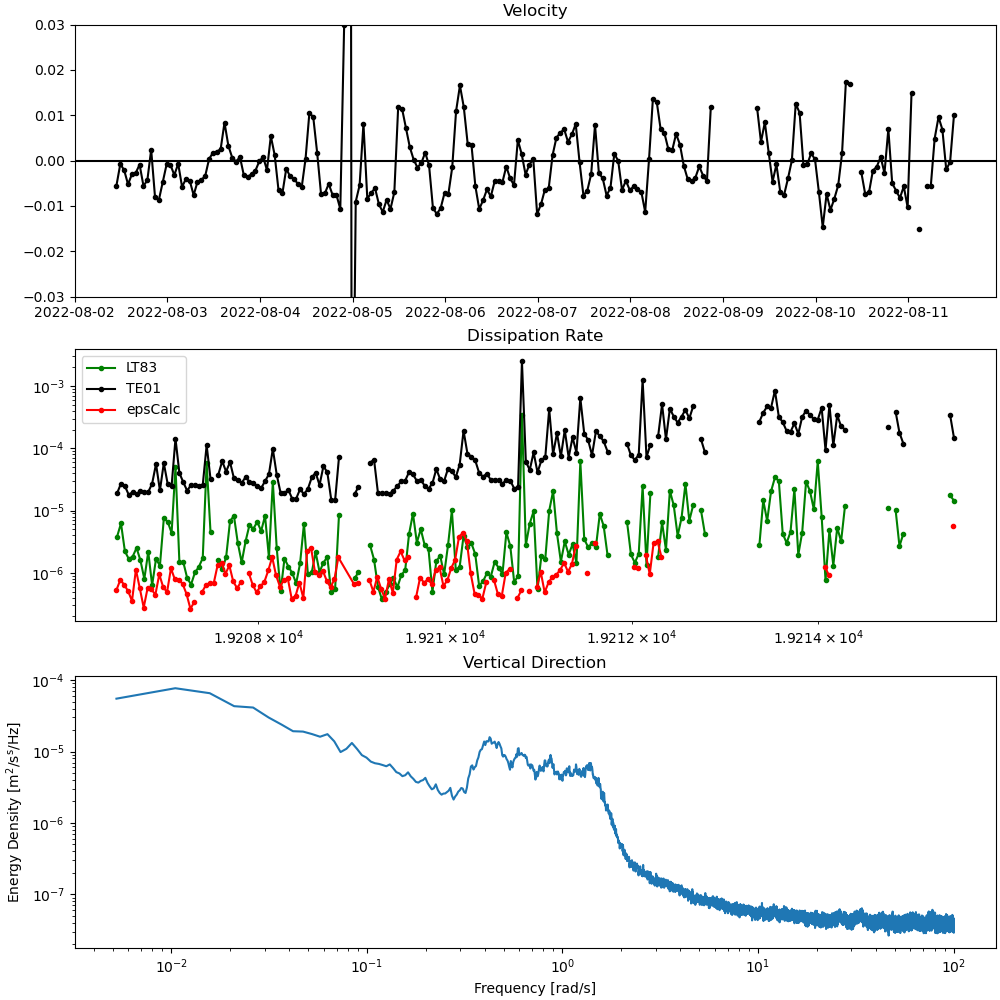

In [237]:
fig, ax = plt.subplots(3,1,constrained_layout=True,figsize = (10, 10))

ax[0].set_title('Velocity')
ax[0].plot(dat_binned.time, dat_binned.vel.sel(dir='streamwise'), '.-k')
ax[0].axhline(y=0, c = 'black')
ax[0].set_ylim(-.03, .03)

ax[1].set_title('Dissipation Rate')
ax[1].loglog(dat_binned.time, dat_binned.dissipation_LT83.sel(S = 'Szz'), '.-g', label = 'LT83')
ax[1].loglog(dat_binned.time, dat_binned.dissipation_TE01, '.-k', label = 'TE01')
ax[1].loglog(eps1.timeStart.values, eps1.eps*(2*np.pi), '.-r', label = 'epsCalc')
ax[1].legend()

ax[2].loglog(dat_binned['freq'], dat_binned['psd'].sel(S='Szz').mean(dim='time'))
ax[2].set_xlabel('Frequency [rad/s]')
ax[2].set_ylabel('Energy Density $\mathrm{[m^2/s^s/Hz]}$')
ax[2].set_title('Vertical Direction')

In [200]:
# At any point you can save the data:
dolfyn.save(dat, 'DOLfYN_tests/standard_adv_data.nc')
dolfyn.save(dat_binned, 'DOLfYN_tests/binned_adv_data.nc')

In [206]:
# And reload the data:
dat = dolfyn.load('DOLfYN_tests/standard_adv_data.nc')
dat_binned = dolfyn.load('DOLfYN_tests/binned_adv_data.nc')

In [214]:
# Calculate dissipation rate from isotropic turbulence cascade
dat_binned['dissipation_LT83'] = binner.calc_epsilon_LT83(dat_binned.auto_spectra, dat_binned.velds.U_mag, freq_range=[2*np.pi,4*np.pi]) #From 1 - 3Hz
dat_binned['dissipation_TE01'] = binner.calc_epsilon_TE01(dat, dat_binned, freq_range=[2*np.pi,4*np.pi]) #From 1 - 3Hz

In [215]:
dat_binned

<xarray.Dataset>
Dimensions:               (time: 225, dir: 3, beam: 3, earth: 3, inst: 3,
                           tke: 3, tau: 3, S: 3, freq: 960)
Coordinates:
  * time                  (time) datetime64[ns] 2022-08-02T09:50:02.953125 .....
  * dir                   (dir) object 'streamwise' 'x-stream' 'vert'
  * beam                  (beam) int32 1 2 3
  * earth                 (earth) object 'E' 'N' 'U'
  * inst                  (inst) object 'X' 'Y' 'Z'
  * tke                   (tke) object 'upup_' 'vpvp_' 'wpwp_'
  * tau                   (tau) object 'upvp_' 'upwp_' 'vpwp_'
  * S                     (S) object 'Sxx' 'Syy' 'Szz'
  * freq                  (freq) float32 0.1047 0.2094 0.3142 ... 100.4 100.5
Data variables: (12/38)
    U_std                 (time) float32 nan 0.08696 0.02469 ... nan nan nan
    batt                  (time) float32 13.65 13.56 13.48 ... 11.17 11.2 11.2
    c_sound               (time) float32 1.528e+03 1.516e+03 ... 1.532e+03
    heading               (time) float32 357.8 100.5 63.44 ... 117.8 70.75 27.03
    pitch                 (time) float32 -16.72 3.031 0.5143 ... -18.88 -18.96
    roll                  (time) float32 19.19 4.47 0.2502 ... -22.3 -22.09
    ...                    ...
    orientmat_var         (earth, inst, time) float32 0.03595 ... 2.726e-07
    mask_var              (dir, time) float32 0.0 0.1684 0.0003124 ... 0.0 0.0
    auto_spectra          (S, time, freq) float32 nan nan nan ... nan nan nan
    dissipation           (S, time) float32 nan nan 0.0001791 ... nan nan nan
    dissipation_LT83      (S, time) float32 nan nan 0.0005607 ... nan nan nan
    dissipation_TE01      (time) float32 nan nan 3.233e-05 ... nan nan nan
Attributes: (12/49)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    declination_in_orientmat:    1
    principal_heading:           43.4644
    n_bin:                       38400
    n_fft:                       1920
    n_fft_coh:                   1920
    description:                 Binned averages calculated from ensembles of...

### ADCP

In [ ]:
# Then read a file containing adv data:
ds = dolfyn.read_example('BenchFile01.ad2cp')

# This ADCP was sitting 0.5 m up from the seabed
# in a tripod
api.clean.set_range_offset(ds, h_deploy=0.5)

# Filter the data by low correlation values (< 50% here)
ds = api.clean.correlation_filter(ds, thresh=50)

# Rotate data from the instrument to true ENU (vs magnetic) frame:
# First set the magnetic declination
dolfyn.set_declination(ds, 10)  # 10 degrees East
dolfyn.rotate2(ds, 'earth')

# At any point you can save the data:
#dolfyn.save(dat_cln, 'adcp_data.nc')

# And reload the data:
#dat_copy = dolfyn.load('adcp_data.nc')